Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [12]:
NAME = "d"
COLLABORATORS = "d"

---

# Classification

## Learning objectives:
* Use Scikit-learn to do simple classification tasks

In [13]:
import os    
import tempfile
os.environ['MPLCONFIGDIR'] = tempfile.mkdtemp()
import operator
import numpy as np
import sklearn.preprocessing
import sklearn.utils
from sklearn.decomposition import PCA 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error, accuracy_score
import sklearn.metrics as sklm
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from functools import partial
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import pickle
from matplotlib import rc
import matplotlib
import pandas as pd
from hyperopt import hp, tpe, fmin, Trials
from rdkit.Chem import AllChem
import pubchempy as pcp
from rdkit import Chem
from rdkit.Chem import MACCSkeys

In [14]:
fs = 10 # font size
fs_label = 10 # tick label size
fs_lgd = 10 # legend font size
ss = 20 # symbol size
ts = 3 # tick size
slw = 1 # symbol line width
framelw = 1 # line width of frame
lw = 2 # line width of the bar box
rc('axes', linewidth=framelw)
plt.rcParams.update({
    "text.usetex": False,
    "font.weight":"bold",
    "axes.labelweight":"bold",
    "font.size":fs,
    'pdf.fonttype':'truetype'
})
plt.rcParams['mathtext.fontset']='stix'

# PART 0: pre-process the data set

We will still use the same data files for your previous HW6.

The data files are given in this folder under `refined_datasets/`

## Instruction:
* For code in this section, you can simply run them 

In [15]:
datapath = 'PAH/' # path to your data folder
filein_test= os.path.join(datapath,'testset_0.ds') # read in the CSV file containing the features. This file is just for example
filein_train= os.path.join(datapath,'trainset_0.ds')
# The dataframe for molecule name and classis
df_test = pd.read_csv(filein_test, sep=" ",  header=None, names=['molecule', 'cancerous'])
df_train = pd.read_csv(filein_train, sep=" ",  header=None, names=['molecule', 'cancerous'])

In [16]:
df_test

,molecule,cancerous
0,2-methylbenzo[c]phenanthrene.ct,1
1,3-methylbenz[a]anthracene.ct,-1
2,"Dibenzo[h,rst]pentaphene.ct",1
3,"1,3-dimethylbenzo[a]pyrene.ct",1
4,8-methylbenzo[a]pyrene.ct,-1
5,10-methylbenzo[a]pyrene.ct,1
6,10-methylbenz[a]anthracene.ct,1
7,"1,6-dimethylbenzo[a]pyrene.ct",1
8,2-methylbenzo[a]pyrene.ct,1
9,benzo[e]pyrene.ct,1


In [17]:
df_train

,molecule,cancerous
0,naphthalene.ct,-1
1,anthracene.ct,-1
2,phenanthrene.ct,-1
3,naphthacene.ct,-1
4,benzo[a]anthracene.ct,1
...,...,...
77,6-methylanthanthrene.ct,1
78,"6,12-dimethylanthanthrene.ct",1
79,"9,10-dimethylanthracene.ct",1
80,coronene.ct,-1


In [18]:
def getSMILES(df):
    mols=df['molecule'].values
    smiles_list = []
    for mol in mols:
        # Get rid of the ".ct" suffix
        # Search Pubchem by the compound name
        results = pcp.get_compounds(mol[:-3], 'name')
        smiles = ""
        if len(results) > 0:
            # Get the SMILES string of the compound
            smiles = results[0].isomeric_smiles
            smiles_list.append(smiles)
            print(mol[:-3],smiles)
        else:
            smiles_list.append(smiles)
            print(mol[:-3],'molecule not found in PubChem')
    df['SMILES'] = smiles_list

In [19]:
mymol = pcp.get_compounds('naphthalene', 'name', record_type='3d')[0]

In [20]:
mydict=mymol.to_dict(properties=['atoms'])

In [21]:
mydict['atoms']

[{'aid': 1, 'number': 6, 'element': 'C', 'x': 0, 'y': -0.7076, 'z': 0},
 {'aid': 2, 'number': 6, 'element': 'C', 'x': 0, 'y': 0.7076, 'z': 0.0001},
 {'aid': 3,
  'number': 6,
  'element': 'C',
  'x': 1.225,
  'y': -1.3944,
  'z': 0.0001},
 {'aid': 4, 'number': 6, 'element': 'C', 'x': 1.225, 'y': 1.3944, 'z': 0},
 {'aid': 5, 'number': 6, 'element': 'C', 'x': -1.225, 'y': -1.3943, 'z': 0},
 {'aid': 6, 'number': 6, 'element': 'C', 'x': -1.225, 'y': 1.3943, 'z': 0},
 {'aid': 7, 'number': 6, 'element': 'C', 'x': 2.4327, 'y': -0.6958, 'z': 0},
 {'aid': 8,
  'number': 6,
  'element': 'C',
  'x': 2.4327,
  'y': 0.6959,
  'z': -0.0001},
 {'aid': 9,
  'number': 6,
  'element': 'C',
  'x': -2.4327,
  'y': -0.6958,
  'z': -0.0001},
 {'aid': 10, 'number': 6, 'element': 'C', 'x': -2.4327, 'y': 0.6958, 'z': 0},
 {'aid': 11,
  'number': 1,
  'element': 'H',
  'x': 1.2489,
  'y': -2.4822,
  'z': 0.0001},
 {'aid': 12,
  'number': 1,
  'element': 'H',
  'x': 1.2489,
  'y': 2.4821,
  'z': -0.0001},
 {'aid

In [22]:
getSMILES(df_train)

naphthalene C1=CC=C2C=CC=CC2=C1
anthracene C1=CC=C2C=C3C=CC=CC3=CC2=C1
phenanthrene C1=CC=C2C(=C1)C=CC3=CC=CC=C32
naphthacene C1=CC=C2C=C3C=C4C=CC=CC4=CC3=CC2=C1
benzo[a]anthracene C1=CC=C2C(=C1)C=CC3=CC4=CC=CC=C4C=C32
chrysene C1=CC=C2C(=C1)C=CC3=C2C=CC4=CC=CC=C43
benzo[c]phenanthrene C1=CC=C2C(=C1)C=CC3=C2C4=CC=CC=C4C=C3
pyrene C1=CC2=C3C(=C1)C=CC4=CC=CC(=C43)C=C2
triphenylene C1=CC=C2C(=C1)C3=CC=CC=C3C4=CC=CC=C24
dibenz[a,h]anthracene C1=CC=C2C(=C1)C=CC3=CC4=C(C=CC5=CC=CC=C54)C=C32
dibenz[a,j]anthracene C1=CC=C2C(=C1)C=CC3=CC4=C(C=C32)C5=CC=CC=C5C=C4
benzo[a]pyrene C1=CC=C2C3=C4C(=CC2=C1)C=CC5=C4C(=CC=C5)C=C3
benzo[c]chrysene C1=CC=C2C(=C1)C=CC3=C2C=CC4=C3C5=CC=CC=C5C=C4
benzo[g]chrysene C1=CC=C2C(=C1)C=CC3=C2C4=CC=CC=C4C5=CC=CC=C35
benzo[a]naphthacene C1=CC=C2C(=C1)C=CC3=CC4=CC5=CC=CC=C5C=C4C=C32
pentaphene C1=CC=C2C=C3C(=CC2=C1)C=CC4=CC5=CC=CC=C5C=C43
dibenz[a,c]anthracene C1=CC=C2C=C3C4=CC=CC=C4C5=CC=CC=C5C3=CC2=C1
pentacene C1=CC=C2C=C3C=C4C=C5C=CC=CC5=CC4=CC3=CC2=C1
dibenzo[c,g

In [23]:
df_train

,molecule,cancerous,SMILES
0,naphthalene.ct,-1,C1=CC=C2C=CC=CC2=C1
1,anthracene.ct,-1,C1=CC=C2C=C3C=CC=CC3=CC2=C1
2,phenanthrene.ct,-1,C1=CC=C2C(=C1)C=CC3=CC=CC=C32
3,naphthacene.ct,-1,C1=CC=C2C=C3C=C4C=CC=CC4=CC3=CC2=C1
4,benzo[a]anthracene.ct,1,C1=CC=C2C(=C1)C=CC3=CC4=CC=CC=C4C=C32
...,...,...,...
77,6-methylanthanthrene.ct,1,CC1=C2C=CC3=C4C2=C5C(=CC4=CC=C3)C=CC6=C5C1=CC=C6
78,"6,12-dimethylanthanthrene.ct",1,CC1=C2C=CC3=C4C2=C5C(=C(C4=CC=C3)C)C=CC6=C5C1=...
79,"9,10-dimethylanthracene.ct",1,CC1=C2C=CC=CC2=C(C3=CC=CC=C13)C
80,coronene.ct,-1,C1=CC2=C3C4=C1C=CC5=C4C6=C(C=C5)C=CC7=C6C3=C(C...


In [24]:
getSMILES(df_test)

2-methylbenzo[c]phenanthrene CC1=CC2=C(C=C1)C=CC3=C2C4=CC=CC=C4C=C3
3-methylbenz[a]anthracene CC1=CC2=C(C=C1)C3=CC4=CC=CC=C4C=C3C=C2
Dibenzo[h,rst]pentaphene C1=CC=C2C3=C4C(=CC2=C1)C5=CC=CC=C5C6=CC7=CC=CC=C7C(=C64)C=C3
1,3-dimethylbenzo[a]pyrene CC1=CC(=C2C=CC3=C4C2=C1C=CC4=CC5=CC=CC=C35)C
8-methylbenzo[a]pyrene CC1=CC2=C(C=C1)C3=C4C(=C2)C=CC5=C4C(=CC=C5)C=C3
10-methylbenzo[a]pyrene CC1=C2C3=C4C(=CC2=CC=C1)C=CC5=C4C(=CC=C5)C=C3
10-methylbenz[a]anthracene CC1=CC2=CC3=C(C=CC4=CC=CC=C43)C=C2C=C1
1,6-dimethylbenzo[a]pyrene CC1=C2C=CC3=C4C2=C(C=C1)C=CC4=C(C5=CC=CC=C35)C
2-methylbenzo[a]pyrene CC1=CC2=C3C(=C1)C=CC4=C3C(=CC5=CC=CC=C45)C=C2
benzo[e]pyrene C1=CC=C2C(=C1)C3=CC=CC4=C3C5=C(C=CC=C25)C=C4


In [25]:
df_test

,molecule,cancerous,SMILES
0,2-methylbenzo[c]phenanthrene.ct,1,CC1=CC2=C(C=C1)C=CC3=C2C4=CC=CC=C4C=C3
1,3-methylbenz[a]anthracene.ct,-1,CC1=CC2=C(C=C1)C3=CC4=CC=CC=C4C=C3C=C2
2,"Dibenzo[h,rst]pentaphene.ct",1,C1=CC=C2C3=C4C(=CC2=C1)C5=CC=CC=C5C6=CC7=CC=CC...
3,"1,3-dimethylbenzo[a]pyrene.ct",1,CC1=CC(=C2C=CC3=C4C2=C1C=CC4=CC5=CC=CC=C35)C
4,8-methylbenzo[a]pyrene.ct,-1,CC1=CC2=C(C=C1)C3=C4C(=C2)C=CC5=C4C(=CC=C5)C=C3
5,10-methylbenzo[a]pyrene.ct,1,CC1=C2C3=C4C(=CC2=CC=C1)C=CC5=C4C(=CC=C5)C=C3
6,10-methylbenz[a]anthracene.ct,1,CC1=CC2=CC3=C(C=CC4=CC=CC=C43)C=C2C=C1
7,"1,6-dimethylbenzo[a]pyrene.ct",1,CC1=C2C=CC3=C4C2=C(C=C1)C=CC4=C(C5=CC=CC=C35)C
8,2-methylbenzo[a]pyrene.ct,1,CC1=CC2=C3C(=C1)C=CC4=C3C(=CC5=CC=CC=C45)C=C2
9,benzo[e]pyrene.ct,1,C1=CC=C2C(=C1)C3=CC=CC4=C3C5=C(C=CC=C25)C=C4


In [26]:

fpgen = AllChem.GetMorganGenerator(radius=2)
mol = Chem.MolFromSmiles("Cn1cnc2c1c(=O)n(C)c(=O)n2C")
fp = fpgen.GetFingerprintAsNumPy(mol)


In [27]:
MACCSkeys.GenMACCSKeys(mol)
np.array(mol)



array(<rdkit.Chem.rdchem.Mol object at 0x7f594fb66b20>, dtype=object)

In [28]:
print(mol)

In [29]:
for i in fp:
    print(i)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [30]:
def getData(df):
    MFP_list = []
    for smiles in df['SMILES'].values:
        mol = Chem.MolFromSmiles(smiles)
        MFP = MACCSkeys.GenMACCSKeys(mol)
        MFP_list.append(MFP)
    X = np.array(MFP_list)
    y_list = []
    for y in df['cancerous']:
        if y == 1:
            y_list.append(1)
        else:
            y_list.append(0)
    y = np.array(y_list)
    return X,y

In [31]:
X_test,y_test = getData(df_test)

In [32]:
'''
def getData(df):
    fpgen = AllChem.GetMorganGenerator(radius=2)
    MFP_list = []
    for smiles in df['SMILES'].values:
        mol = Chem.MolFromSmiles(smiles)
        MFP = fpgen.GetFingerprintAsNumPy(mol)
        MFP_list.append(MFP)
    X = np.array(MFP_list)

    y_list = []
    for y in df['cancerous']:
        if y == 1:
            y_list.append(1)
        else:
            y_list.append(0)
    y = np.array(y_list)
    return X,y
    '''

"\ndef getData(df):\n    fpgen = AllChem.GetMorganGenerator(radius=2)\n    MFP_list = []\n    for smiles in df['SMILES'].values:\n        mol = Chem.MolFromSmiles(smiles)\n        MFP = fpgen.GetFingerprintAsNumPy(mol)\n        MFP_list.append(MFP)\n    X = np.array(MFP_list)\n\n    y_list = []\n    for y in df['cancerous']:\n        if y == 1:\n            y_list.append(1)\n        else:\n            y_list.append(0)\n    y = np.array(y_list)\n    return X,y\n    "

In [33]:
print(X_test)

[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]]


In [34]:
X_train,y_train = getData(df_train)

# Train a SVM and get the ROC curve

In [35]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

SVC()

In [36]:
clf.predict(X_test)

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 0])

In [37]:
y_test

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 1])

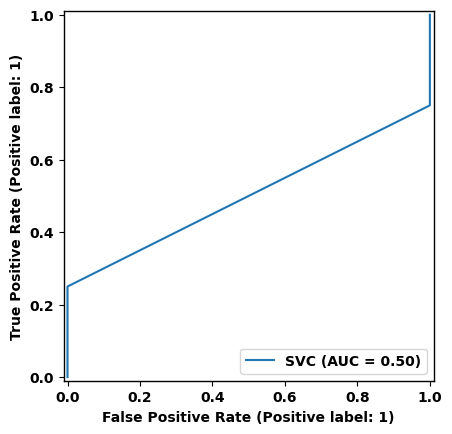

In [38]:
from sklearn.metrics import RocCurveDisplay
svc_disp = RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.show()

# Train a random forest and get the ROC curve

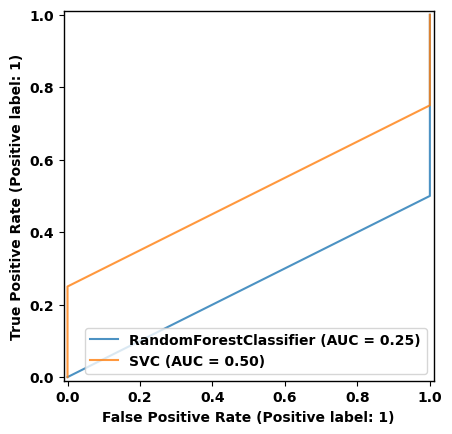

In [39]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10, random_state=42)
rfc.fit(X_train, y_train)
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rfc, X_test, y_test, ax=ax, alpha=0.8)
svc_disp.plot(ax=ax, alpha=0.8)
plt.show()

# Logistic regression

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
clf_lg = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.predict(X_test)

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 0])

In [42]:
y_test

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 1])

# Upsampling

In [43]:
from sklearn.utils import resample,shuffle
df_0 = df_train[df_train['cancerous'] == -1]
df_1 = df_train[df_train['cancerous'] == 1]

In [44]:
len(df_0), len(df_1)

(32, 50)

In [45]:
df_0_upsampled = resample(df_0,random_state=42,n_samples=50,replace=True)

In [46]:
len(df_0_upsampled)

50

In [47]:
df_0_upsampled

,molecule,cancerous,SMILES
14,benzo[a]naphthacene.ct,-1,C1=CC=C2C(=C1)C=CC3=CC4=CC5=CC=CC=C5C=C4C=C32
30,"dibenzo[a,l]naphthacene.ct",-1,C1=CC=C2C(=C1)C=CC3=CC4=C(C=C32)C=C5C(=C4)C=CC...
60,2-methylpyrene.ct,-1,CC1=CC2=C3C(=C1)C=CC4=CC=CC(=C43)C=C2
23,anthanthrene.ct,-1,C1=CC2=C3C(=C1)C=C4C=CC5=C6C4=C3C(=CC6=CC=C5)C=C2
19,picene.ct,-1,C1=CC=C2C(=C1)C=CC3=C2C=CC4=C3C=CC5=CC=CC=C54
15,pentaphene.ct,-1,C1=CC=C2C=C3C(=CC2=C1)C=CC4=CC5=CC=CC=C5C=C43
60,2-methylpyrene.ct,-1,CC1=CC2=C3C(=C1)C=CC4=CC=CC(=C43)C=C2
31,"dibenzo[a,j]naphthacene.ct",-1,C1=CC=C2C(=C1)C=CC3=CC4=C(C=C5C=CC6=CC=CC=C6C5...
14,benzo[a]naphthacene.ct,-1,C1=CC=C2C(=C1)C=CC3=CC4=CC5=CC=CC=C5C=C4C=C32
44,"1,12-dimethylbenz[a]anthracene.ct",-1,CC1=C2C(=CC=C1)C=CC3=CC4=CC=CC=C4C(=C32)C


In [48]:
df_upsampled = pd.concat([df_0_upsampled,df_1])

In [49]:
X_train_up,y_train_up = getData(df_upsampled)

In [50]:
clf_lg = LogisticRegression(random_state=0).fit(X_train_up, y_train_up)
clf.predict(X_test)

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 0])